Enfoque del dataset de noticias falsas basado en CNN

In [1]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Cargar Dataset

In [2]:
### GOOGLE DRIVE ###
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/My Drive/TFM/Data/MAMI/"

Mounted at /content/drive


In [3]:
### PARTICIÓN ###
df = pd.read_csv(PATH + "training.csv",  sep=",", on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore', index_col=False)
df = df[['Text Transcription', 'shaming', 'stereotype', 'objectification', 'violence']]
df = df.rename(columns={"Text Transcription": "Text", "shaming": "Label1", "stereotype": "Label2", "objectification": "Label3", "violence": "Label4"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = pd.DataFrame({'Label1':df['Label1'], 'Label2':df['Label2'], 'Label3':df['Label3'], 'Label4':df['Label4']})

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.3, random_state=55)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.66, random_state=55)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 5416
Tamaño conjunto de Validación: 789
Tamaño conjunto de Evaluación: 1533


# Preprocesamiento y Limpieza

In [4]:
### LIMPIEZA DE TEXTOS ###
stopwords_es = stopwords.words("english")
def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 2 caráceres
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial
    min_length = 2
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=""
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens = filtered_tokens + str(token) + " "

    if filtered_tokens == "":
        return "nada"
    else:
        return filtered_tokens

for index in X_train.index:
    X_train[index] = clean_text(X_train[index])

# Label Encoding

No es necesario hacer Label Encoding

# Tokenización

In [5]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 8335


In [6]:
MAX_LEN = 58

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# Matriz de Embedding

In [7]:
#model_we = api.load("glove-wiki-gigaword-50")       #EMBED_SIZE = 50
#model_we = api.load("glove-twitter-200")          #EMBED_SIZE = 200
#model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

model_we = api.load("glove-twitter-200")
EMBED_SIZE = 200

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

[==================================================] 100.0% 758.5/758.5MB downloaded


# CNN

In [8]:
EMBEDDING_SIZE = EMBED_SIZE
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN, weights=[embedding_matrix]))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 200)           1667000   
                                                                 
 conv1d (Conv1D)             (None, 58, 128)           102528    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 32)            4

Training:

In [9]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16

# training
history=model.fit(encoded_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val), callbacks=[earlyStopping])


Epoch 1/20
339/339 [==============================] - 26s 46ms/step - loss: 0.4533 - accuracy: 0.2053 - val_loss: 0.4373 - val_accuracy: 0.2091
Epoch 2/20
339/339 [==============================] - 4s 13ms/step - loss: 0.3887 - accuracy: 0.2350 - val_loss: 0.4411 - val_accuracy: 0.2269
Epoch 3/20
339/339 [==============================] - 4s 12ms/step - loss: 0.3072 - accuracy: 0.3013 - val_loss: 0.4879 - val_accuracy: 0.2877
Epoch 4/20
339/339 [==============================] - 2s 7ms/step - loss: 0.2252 - accuracy: 0.3977 - val_loss: 0.5405 - val_accuracy: 0.3181


Curvas de Aprendizaje:

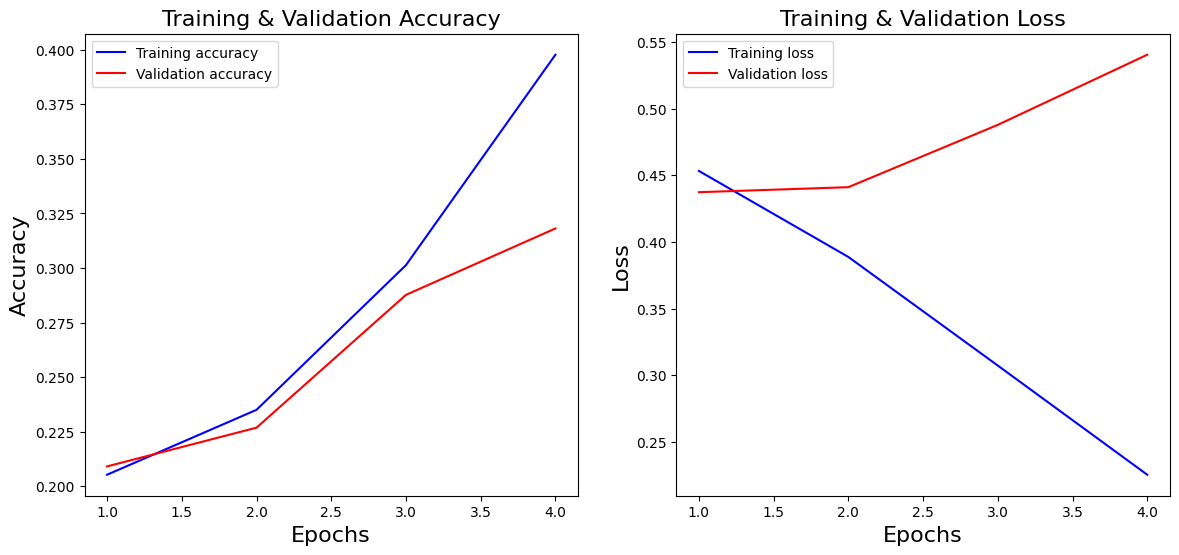

In [10]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluación:

In [11]:
loss, accuracy = model.evaluate(encoded_test, y_test, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
y_test_2 = np.asmatrix(y_test)
rounded_y_test = np.argmax(y_test_2, axis=1)

print(classification_report(np.asarray(rounded_y_test), y_pred))

48/48 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.20      0.32      1008
           1       0.29      0.59      0.39       306
           2       0.16      0.49      0.24       172
           3       0.14      0.43      0.21        47

    accuracy                           0.32      1533
   macro avg       0.36      0.43      0.29      1533
weighted avg       0.63      0.32      0.32      1533

